In [ ]:
# data set
# https://archive.ics.uci.edu/ml/machine-learning-databases/00352/
# conteúdo
# https://guillaume-martin.github.io/rfm-segmentation-with-python.html
# https://www.kaggle.com/nguncedasci/online-retail-2010-2011-rfm-analysis
#https://materialui.co/colors/
#https://www.kaggle.com/mustafacicek/marketing-analytics-rfm-analysis

### Preparação dos dados

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import numpy as np

In [2]:
#pip install xlrd

In [3]:
#pip install openpyxl #para ler o xlsx caso não esteja instalado

In [4]:
#leitura da base - o arquivo deve estar como UTF-8
sales = pd.read_excel('Online Retail.xlsx' ,engine='openpyxl')
sales.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print('{:,} rows; {:,} columns'.format(sales.shape[0], sales.shape[1]))

541,909 rows; 8 columns


In [7]:
sales.dropna(subset=['CustomerID'], inplace=True)

In [8]:
print('Orders from {} to {}'.format(sales['InvoiceDate'].min(),
                                    sales['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [9]:
sales['Price'] = sales['Quantity'] * sales['UnitPrice']

In [10]:
sales['InvoiceNo'].value_counts().head()

576339    542
579196    533
580727    529
578270    442
573576    435
Name: InvoiceNo, dtype: int64

### RFM /RFV  

In [11]:
orders = sales.groupby(['InvoiceNo', 'InvoiceDate', 'CustomerID']).agg({'Price': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,InvoiceDate,CustomerID,Price
0,536365,2010-12-01 08:26:00,17850.0,139.12
1,536366,2010-12-01 08:28:00,17850.0,22.20
2,536367,2010-12-01 08:34:00,13047.0,278.73
3,536368,2010-12-01 08:34:00,13047.0,70.05
4,536369,2010-12-01 08:35:00,13047.0,17.85


In [12]:
NOW = orders['InvoiceDate'].max() + timedelta(days=1)
NOW

Timestamp('2011-12-10 12:50:00')

In [13]:
period = 365

In [14]:
orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (NOW - x).days)

In [15]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,326,2
1,12347.0,2,6
2,12348.0,75,4
3,12349.0,19,1
4,12350.0,310,1


In [16]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['InvoiceDate'] >= NOW - timedelta(days=period))]\
                                                           ['Price'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,6,3598.21
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [17]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 11.0, 0.4: 32.0, 0.6: 71.0, 0.8: 178.80000000000018},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 6.0},
 'Monetary': {0.2: 215.89800000000002,
  0.4: 440.432,
  0.6: 876.3679999999999,
  0.8: 1909.6580000000006}}

In [18]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [19]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [20]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,6,3598.21,5,4,5,545
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


#### Interpretação dos resultados por segmento

**Champions:** Comprou recentemente e compra com frequência além de gastar mais gaste mais

**Loyal Customers:**	Compra regularmente, podemos considerar responsivo as promoções

**Potential Loyalist:**	Clientes recentes com frequencia de compra

**Recent Customers:**	Comprou recentemente, mas não possui frequencia

**Promising:**	Compradores recentes, mas não gastaram muito

**Customers Needing Attention:**	Recência, frequência e valores monetários acima da média. Pode não ter comprado muito recentemente.

**About To Sleep:**	Recência e frequência abaixo da média. Vai perdê-los se não for reativado.

**At Risk:**	Comprador com frequência, mas há muito tempo. Precisa trazê-los de volta!

**Can’t Lose Them:**	Costumava comprar com frequência, mas não voltava há muito tempo.

**Hibernating:**	A última compra foi há muito tempo e com baixo número de pedidos. Pode ser perdido.

In [21]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12346.0,326,2,0.00,1,2,1,121,hibernating
1,12347.0,2,6,3598.21,5,4,5,545,champions
2,12348.0,75,4,1797.24,2,4,4,244,at risk
3,12349.0,19,1,1757.55,4,1,4,414,promising
4,12350.0,310,1,334.40,1,1,2,112,hibernating


In [22]:
rfm_level_agg = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                    Recency Frequency Monetary      
                       mean      mean     mean count
Segment                                             
about to sleep         51.8       1.4    453.2   441
at risk               143.7       3.9   1125.0   400
can't loose           130.4       9.2   2497.3    64
champions               5.4      14.5   6492.4   630
hibernating           211.3       1.2    369.0  1271
loyal customers        32.1       7.9   2666.7   793
need attention         49.3       3.0    870.4   111
new customers           6.7       1.0    338.7    63
potential loyalists    15.4       2.4    750.3   432
promising              22.8       1.0    294.5   167


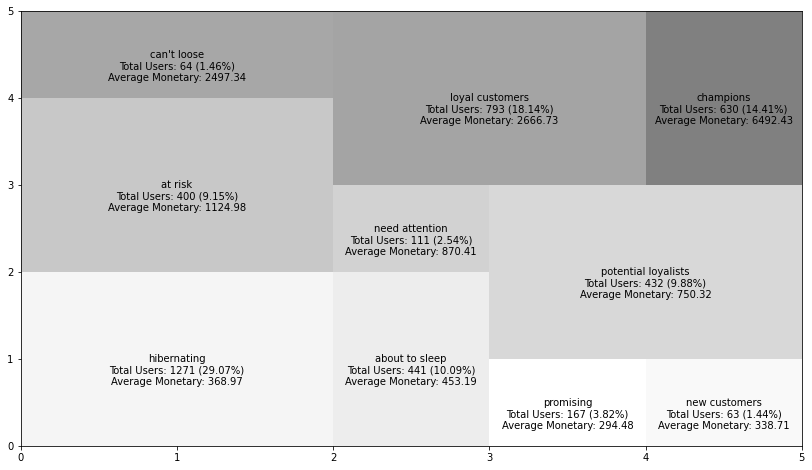

In [30]:
rfm_matrix = pd.DataFrame({"champions": [3, 5, 0.8, 1],
                   "loyal customers": [3, 5, 0.4, 0.8],
                   "can\'t loose": [4, 5, 0, 0.4],
                   "at risk": [2, 4, 0, 0.4],
                   "hibernating": [0, 2, 0, 0.4],
                   "about to sleep": [0, 2, 0.4, 0.6],
                   "promising": [0, 1, 0.6, 0.8],
                   "new customers": [0, 1, 0.8, 1],
                   "potential loyalists": [1, 3, 0.6, 1],
                   "need attention": [2, 3, 0.4, 0.6]}).transpose().reset_index()
rfm_matrix.columns = ['segment', 'f_min', 'f_max', 'r_min', 'r_max']

fig, ax = plt.subplots(figsize = (14, 8))
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

mon_min = rfm.groupby('Segment')['Monetary'].mean().min()
mon_max = rfm.groupby('Segment')['Monetary'].mean().max()

for segment in rfm_matrix['segment'].tolist():
    r,g,b = 0.5,0.5,0.5
    avg_monetary = rfm[rfm.Segment == segment]["Monetary"].mean()
    a = (np.log(avg_monetary)-np.log(mon_min))/(np.log(mon_max)-np.log(mon_min))
    df = rfm_matrix.loc[rfm_matrix['segment']==segment].reset_index(drop=True)
    ymi, yma, xmi, xma = df['f_min'][0], df['f_max'][0], df['r_min'][0], df['r_max'][0]
    ax.axhspan(ymin = ymi, ymax = yma, xmin = xmi, xmax = xma, facecolor=(r,g,b,a))
    users_percentage = (rfm[rfm.Segment == segment].shape[0] / rfm.shape[0]) * 100
    users_Tot = (rfm[rfm.Segment == segment].shape[0] ) 
    
    user_txt = "\n\nTotal Users: "  +  str(round(users_Tot, 2)) + " (" +  str(round(users_percentage, 2)) + "%)"
    
    
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    plt.text(y=(ymi+yma)/2, x=5*(xmi+xma)/2, s=segment, ha='center', va='center')
    plt.text(y=(ymi+yma)/2, x=5*(xmi+xma)/2, s=user_txt, ha='center', va='center')
    plt.text(y=(ymi+yma)/2, x=5*(xmi+xma)/2, s=monetary_txt, ha='center', va='center')

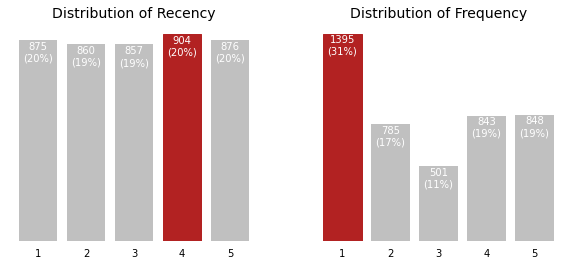

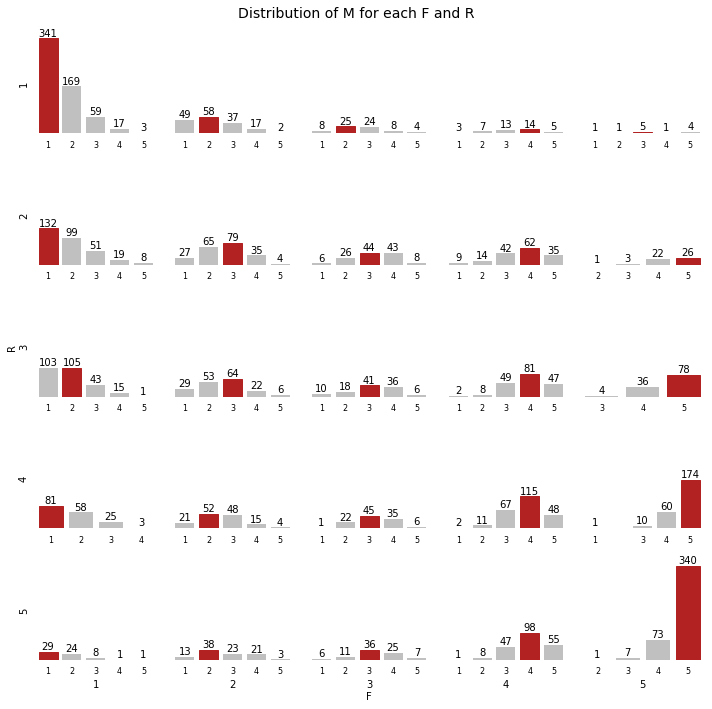

In [31]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

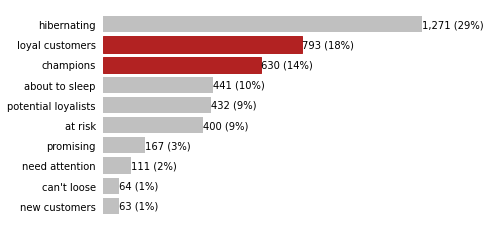

In [32]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()